# Starter code for Cloud Classification Challenge

This code is designed as starter point for your development. You do not have to use it, but feel free to use it if you do not know where to start.

The [Pytorch](https://pytorch.org/) collection of packages is used to define and train the model, and this code is adapted from their [introductory tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html).

Other machine learning python packages that you may wish to use include [TensorFlow](https://www.tensorflow.org/overview) and [scikit-learn](https://scikit-learn.org/stable/index.html).

In [1]:
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1' # set to prevent pytorch_lightning.trainer from breaking

import pandas as pd
import torch
from torch.nn import functional as F
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchmetrics.functional.classification import multiclass_accuracy
import mlflow.pytorch
from mlflow import MlflowClient
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib import pyplot as plt

## Create Custom Dataset for sat images

Dataset instance reads in the directory to the images and their labels.
The dataloader enables simple iteration over these images when training and testing a model.


In [2]:
# Define transforms for label data
def get_label_dict():
    label_dict = {"Fish": 0,
                  "Flower": 1,
                  "Gravel": 2,
                  "Sugar": 3}
    return label_dict


def sat_label_transform(label):
    label_dict = get_label_dict()
    return label_dict[label]


def sat_label_transform_inv(num):
    label_dict = get_label_dict()
    ret_list = [key for key in label_dict.keys() if label_dict[key]==num]
    return ret_list[0]

In [3]:
# Define the transform for images.
# Converts to float and scales values to range 0-1.
# Normalisation using the mean/std used by AlexNet.
img_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

In [4]:
# Create class for loading the satellite image into a Dataset
class SatImageDataset(Dataset):
    def __init__(self, labels_file, img_dir, transform=img_transform, target_transform=sat_label_transform):
        self.img_labels = pd.read_csv(labels_file)[:1000] # TODO: remove, used for testing
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels["Image"].iloc[idx])
        image = read_image(img_path)
        label = self.img_labels["Label"].iloc[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Load the training and testing data using instances of the SatImageDataset defined above.

In [5]:
# Load the training data.
train_files_dir = "/data/users/meastman/understanding_clouds_kaggle/input/single_labels/224s/train/"
train_files_labels = "/data/users/meastman/understanding_clouds_kaggle/input/single_labels/224s/train/train_labels.csv"

# Create train images dataloader
train_images = SatImageDataset(labels_file=train_files_labels, img_dir=train_files_dir)
train_dataloader = DataLoader(train_images, batch_size=32, shuffle=True)

In [6]:
# Test Data
test_files_dir = "/data/users/meastman/understanding_clouds_kaggle/input/single_labels/224s/test/"
test_files_labels = "/data/users/meastman/understanding_clouds_kaggle/input/single_labels/224s/test/test_labels.csv"

# Create test images dataloader
test_images = SatImageDataset(labels_file=test_files_labels, img_dir=test_files_dir)
test_dataloader = DataLoader(test_images, batch_size=32, shuffle=True)

## Building a Neural Network

This is a single layer neural network. For more details on the individual layers, and for further options if you wish to create a different model architecture see [the tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

Note that the input to the layer has size `150528 = 3*224*224`. The input images are 224 * 224 pixels, with 3 RGB channels.

The output layer has size 4 which matches the number of cloud categories available.

In [7]:
def class_aware_focal_loss(logits, targets, weights, alpha=1.0, gamma=2.0):
    ce_loss = F.cross_entropy(logits, targets, weights, reduction='none')
    pt = torch.exp(-ce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    return focal_loss.mean()


def weighted_dist(arr):
    # Calculate the center of the array
    center = np.array(arr.shape) / 2
    
    # Create an array of distances from each point to the center
    distances = np.linalg.norm(np.indices(arr.shape) - center[:, np.newaxis, np.newaxis], axis=0)
    
    # Avoid division by zero for the center point
    distances[int(center[0]), int(center[1])] = 1.0
    
    # Calculate the value divided by distance for each point
    values_divided_by_distances = arr / distances
    
    # Calculate the mean of the values divided by distances
    result = np.mean(values_divided_by_distances)
    
    return result


class NNCloudClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.conv3 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.resconv1 = torch.nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1)
        self.dropout = torch.nn.Dropout2d(p=0.2)
        self.bn3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = torch.nn.BatchNorm2d(128)
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = torch.nn.BatchNorm2d(256)
        self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn6 = torch.nn.BatchNorm2d(256)
        self.conv7 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn7 = torch.nn.BatchNorm2d(256)
        self.conv8 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn8 = torch.nn.BatchNorm2d(256)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(256 * 7 * 7, 128)  # Assuming input size is 224x224
        self.fc2 = torch.nn.Linear(128, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 8)
        self.fc5 = torch.nn.Linear(12, 8)
        self.fc6 = torch.nn.Linear(8, 4)
        
        self.test_outputs = []
        self.avg_test_acc = None
        self.confusion = []

    def forward(self, x):
        """
        :param x: Input data

        :return: output - mnist digit label for the input image
        """

        x = -1 * x[:, 0, :, :]
        batch_size = x.shape[0]
        x_std = torch.std(x, dim=(1, 2)).reshape(batch_size, 1)
        x_mean = torch.mean(x, dim=(1, 2)).reshape(batch_size, 1)
        x = np.abs(np.fft.fftshift(np.fft.fft2(x, axes=(1,2))))
        x_fft_std = torch.std(torch.tensor(x, dtype=torch.float), dim=(1, 2)).reshape(batch_size, 1)
        x_fft_freq_spread = np.zeros((batch_size, 1))
        for i in range(batch_size):
            x_fft_freq_spread[i] = weighted_dist(x[i])
        
        x = torch.tensor(x.reshape(batch_size, 1, 224, 224), dtype=torch.float)
        # Initial convolution and pooling
        x1 = self.pool(F.relu(self.bn1(self.conv1(x))))
        x2 = self.pool(F.relu(self.bn2(self.conv2(x1))))
        x3 = self.pool(F.relu(self.bn3(self.conv3(x2))))
        x3 = self.dropout(x3)

        # Residual connections
        x4 = self.pool(F.relu(self.bn4(self.conv4(x3))))
        x5 = self.pool(F.relu(self.bn5(self.conv5(x4))))
        
        # Merge early layers with later layers

        x3_resized = F.avg_pool2d(x3, kernel_size=(4, 4))
        x3_resized = self.resconv1(x3_resized)

        x5 = x5 + x3_resized  # Adding residual connection
        
        x6 = torch.relu(self.bn6(self.conv6(x5)))
        x7 = torch.relu(self.bn7(self.conv7(x6)))
        x8 = torch.relu(self.bn8(self.conv8(x7)))
        
        x8 = x8 + x5 # Adding residual connection
        
        x = x8.view(x8.size(0), -1)  # Flatten the tensor
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.cat((x, x_std.to(torch.float)), dim=1)
        x = torch.cat((x, x_mean.to(torch.float)), dim=1)
        x = torch.cat((x, x_fft_std.to(torch.float)), dim=1)
        x = torch.cat((x, torch.tensor(x_fft_freq_spread, dtype=torch.float64)), dim=1)
        x = torch.relu(self.fc5(x.to(torch.float)))
        x = self.fc6(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        #w = torch.Tensor([0.95,1.1,1.05,0.75])
        w = torch.Tensor([1.0, 1.0, 1.0, 0.9])
        loss = class_aware_focal_loss(logits, y, w)
        pred = logits.argmax(dim=1)
        acc = multiclass_accuracy(pred, y, num_classes=4)

        # Use the current of PyTorch logger
        self.log("train_loss", loss, on_epoch=True)
        self.log("acc", acc, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        """
        Performs test and computes the accuracy of the model

        :param test_batch: Batch data
        :param batch_idx: Batch indices

        :return: output - Testing accuracy
        """
        x, y = test_batch
        output = self.forward(x)
        _, y_hat = torch.max(output, dim=1)
        test_acc = multiclass_accuracy(y_hat, y, num_classes=4)
        self.test_outputs.append(test_acc)
        self.confusion.append(confusion_matrix(y.numpy(), y_hat.numpy()))
        return {"test_acc": test_acc}
    
    def on_test_epoch_end(self):
        """
        Computes average test accuracy score
        """
        self.avg_test_acc = torch.stack(self.test_outputs).mean()
        total_confusion = np.zeros((4, 4), dtype=int)
    
        # Sum up confusion matrices from all batches
        for x in self.confusion:
            total_confusion += np.array(x)
            
        self.log("avg_test_acc", self.avg_test_acc, sync_dist=True)
        plt.figure(figsize=(10, 8))
        plt.imshow(total_confusion, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.colorbar()
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.xticks(np.arange(4))
        plt.yticks(np.arange(4))
        plt.savefig("confusion_matrix.png")
        self.test_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    
# class NNCloudClassifierNew(pl.LightningModule):
#     def __init__(self):
#         super().__init__()
#         self.l1 = torch.nn.Linear(3, 4)
        
#         self.test_outputs = []
#         self.avg_test_acc = None
#         self.confusion = []

#     def forward(self, x):
#         """
#         :param x: Input data

#         :return: output - mnist digit label for the input image
#         """
#         batch_size = x.shape[0]

        
#         x = x[:, 0, :, :]
#         x_fft = np.abs(np.fft.fftshift(np.fft.fft2(x, axes=(1,2))))
#         x_fft_std = torch.std(torch.tensor(x_fft), dim=(1,2))
        
#         cov_matrices = np.zeros((batch_size, 224*224, 224*224), dtype=np.float32)
#         elipticalness = []
# #         print("1")
#         for i in range(batch_size):
#             flattened_ffts = x_fft[i].reshape(1, -1)        
#             cov_matrices[i] = np.cov(flattened_ffts, rowvar=False)
#             eigvals, eigvecs = np.linalg.eigh(cov_matrices[i])
#             elipticalness_ratio = eigvals[:, -1] / eigvals[:, 0]
#             elipticalness.append(elipticalness_ratio)
        
#         print(elipticalness)
            
# #         print("2")
# #         eigenvals, eigenvecs = np.linalg.eigh(cov_mat)
# #         print("3")
# #         eliptical_ratios = eigenvals[:, -1] / eigenvalues[:, 0]
# #         print("4")
# #         print(eliptical_ratios)

#         x_mean = torch.mean(x, dim=(1,2))
#         x_std = torch.std(x, dim=(1,2))
        
#         x_tens = torch.zeros((batch_size, 3))
#         x_tens[:, 0] = x_mean
#         x_tens[:, 1] = x_std
#         x_tens[:, 2] = x_fft_std/500
                        
#         x = torch.relu(self.l1(x_tens))
#         return x

#     def training_step(self, batch, batch_nb):
#         x, y = batch
#         logits = self(x)
#         loss = F.cross_entropy(logits, y)
#         pred = logits.argmax(dim=1)
#         acc = multiclass_accuracy(pred, y, num_classes=4)

#         # Use the current of PyTorch logger
#         self.log("train_loss", loss, on_epoch=True)
#         self.log("acc", acc, on_epoch=True)
#         return loss
    
#     def test_step(self, test_batch, batch_idx):
#         """
#         Performs test and computes the accuracy of the model

#         :param test_batch: Batch data
#         :param batch_idx: Batch indices

#         :return: output - Testing accuracy
#         """
#         x, y = test_batch
#         output = self.forward(x)
#         _, y_hat = torch.max(output, dim=1)
#         test_acc = multiclass_accuracy(y_hat, y, num_classes=4)
#         self.test_outputs.append(test_acc)
#         self.confusion.append(confusion_matrix(y.numpy(), y_hat.numpy()))
#         return {"test_acc": test_acc}
    
#     def on_test_epoch_end(self):
#         """
#         Computes average test accuracy score
#         """
#         self.avg_test_acc = torch.stack(self.test_outputs).mean()
#         total_confusion = np.zeros((4, 4), dtype=int)
    
#         # Sum up confusion matrices from all batches
#         for x in self.confusion:
#             total_confusion += np.array(x)
            
#         self.log("avg_test_acc", self.avg_test_acc, sync_dist=True)
#         plt.figure(figsize=(10, 8))
#         plt.imshow(total_confusion, interpolation='nearest', cmap=plt.cm.Blues)
#         plt.title("Confusion Matrix")
#         plt.colorbar()
#         plt.xlabel("Predicted labels")
#         plt.ylabel("True labels")
#         plt.xticks(np.arange(4))
#         plt.yticks(np.arange(4))
#         plt.savefig("confusion_matrix.png")
#         self.test_outputs.clear()

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=0.02)
    
    
    

In [8]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/h03/dcubbon/.conda/envs/cloud_class/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
2023/08/17 13:56:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/h03/dcubbon/.conda/envs/cloud_class/lib/python3.11/site-packages/mlflow/pytorch/_lightning_autolog.py:351: UserWarning: Autologging is known to be compati

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=6` reached.
2023/08/17 13:59:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/h03/dcubbon/.conda/envs/cloud_class/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
SLURM auto-requeueing enabled. Setting signal handlers.
/home/h03/dcubbon/.conda/envs/cloud_class/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/h03/dcubbon/.conda/envs/cloud_class/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_test_acc                 0.25
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
run_id: 5c8f6f89be2e48fcafa5eae929cfcfac
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'epochs': '6', 'optimizer_name': 'Adam', 'lr': '0.02', 'betas': '(0.9, 0.999)', 'eps': '1e-08', 'weight_decay': '0', 'amsgrad': 'False', 'maximize': 'False', 'foreach': 'None', 'capturable': 'False', 'differentiable': 'False', 'fused': 'None'}
metrics: {'train_loss': 0.724059522151947, 'train_loss_step': 0.7266092896461487, 'acc': 0.25066667795181274, 'acc_step': 0.3333333432674408, '

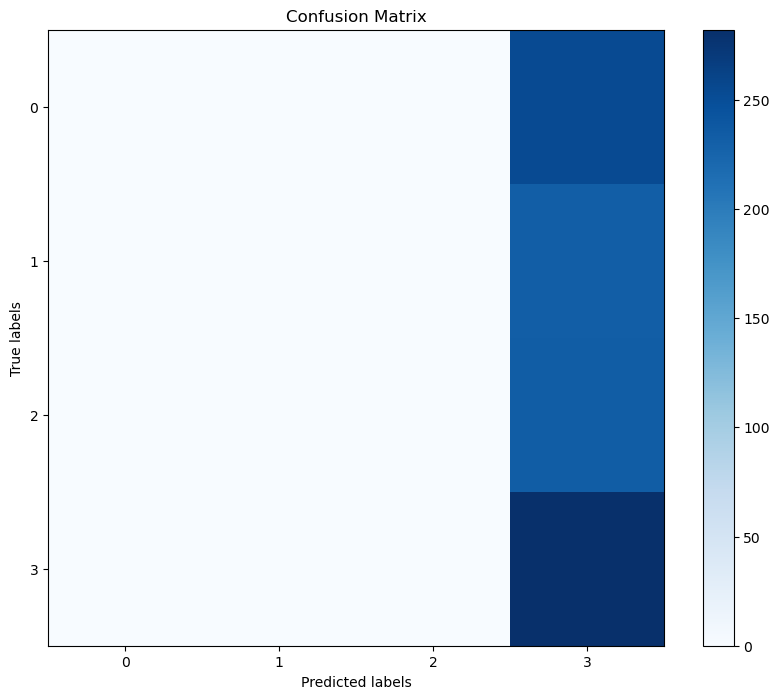

In [9]:
# Initialize our model
classifier = NNCloudClassifier()

# Initialize a trainer
trainer = pl.Trainer(max_epochs=6, devices=1, num_nodes=1)

# Auto log all MLflow entities
mlflow.pytorch.autolog()

# Train the model
with mlflow.start_run() as run:
    trainer.fit(classifier, train_dataloader)
    trainer.test(classifier, test_dataloader)
    mlflow.log_metric('avg_test_acc', classifier.avg_test_acc)
    
# fetch the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

###### 